# plot colony level gene expression over time

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import glob
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression

In [3]:
# set plot sytle
sns.set(
    style='ticks', 
    context='talk', 
    rc={
        "axes.spines.top": False, 
        "axes.spines.right": False,
        "figure.figsize": (10, 6)
    }
)

## set path and read csv

In [ ]:
# get data/results path
data_directory = '../Data/Cluster_Results/'

# result_directory = './01_Clustered_Results'
# if not os.path.exists(result_directory):
#     os.makedirs(result_directory)

In [4]:
# Get a list of all CSV files in the directory
csv_files = glob.glob(data_directory + '*.csv')

# Create an empty list to store the dataframes
dfs = []

# Iterate over each CSV file and read it into a dataframe
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate the dataframes into a single dataframe
combined_df = pd.concat(dfs)

df_all = combined_df.copy()



/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_67799/321452400.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [5]:
df_all = pd.read_csv(os.path.join(data_directory, 'all_clustered_results_cleaned.csv'))

/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_56920/162915097.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(os.path.join(data_directory, 'all_clustered_results_cleaned.csv'))


In [5]:
# calculate and make some new columns
df_all['normalized_GFP'] = df_all['fluo2'] / df_all['fluo1']
df_all['time'] = df_all['frames']*0.25

# if  not os.path.exists(os.path.join(data_directory, "all_clustered_results.csv")):
#     df_all.to_csv(os.path.join(data_directory, "all_clustered_results.csv"), index=False)

# check columns
df_all.columns

Index(['Unnamed: 0', 'id', 'mother', 'frames', 'daughters', 'new_pole',
       'old_pole', 'edges', 'length', 'width', 'area', 'perimeter', 'fluo1',
       'fluo2', 'x', 'y', 'IntDen', 'series', 'Autoinducer', 'gene', 'new_y',
       'new_x', 'Group', 'cluster', 'normalized_GFP', 'time'],
      dtype='object')

In [6]:
df_all = df_all[df_all['Autoinducer'] == 'Without']

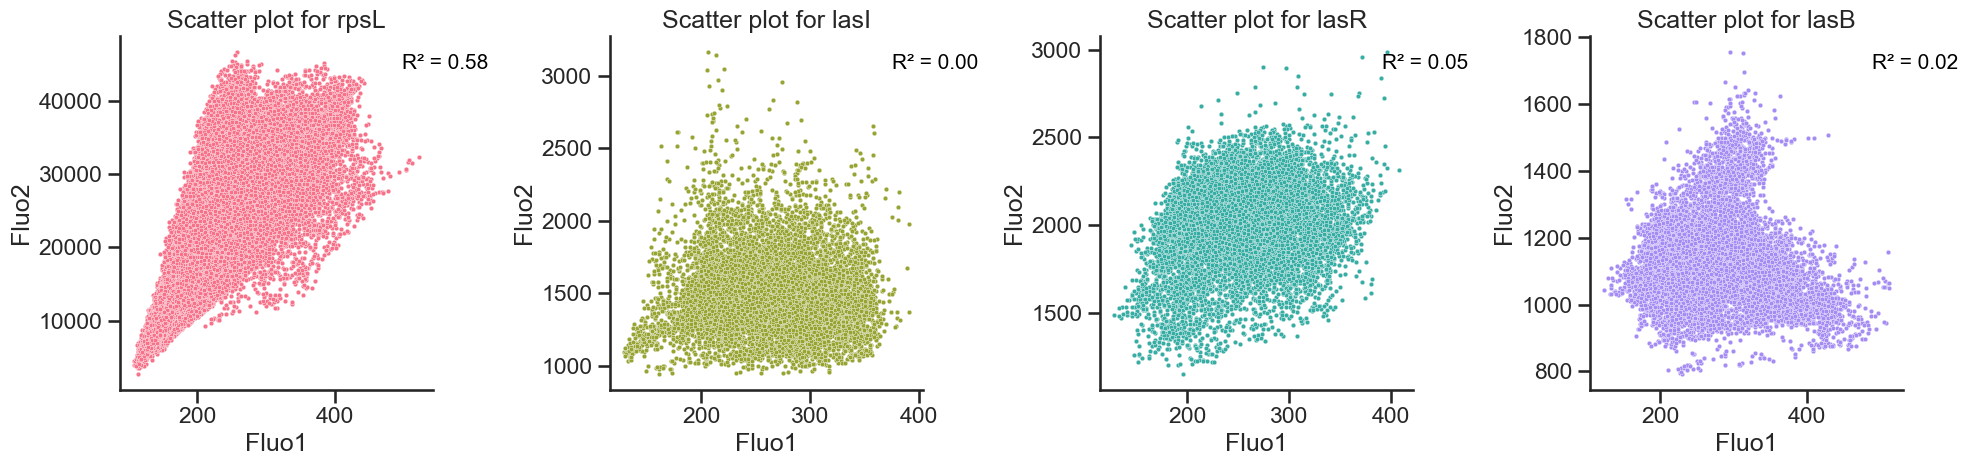

In [8]:
# Plot for housekeeping gene and QS genes correlation scatter plot
genes = ['rpsL', 'lasI', 'lasR', 'lasB']
palette = sns.color_palette("husl", len(genes))  # Generate a color palette

fig, axes = plt.subplots(nrows=1, ncols=len(genes), figsize=(20, 5), sharey=False)
for ax, gene, color in zip(axes, genes, palette):
    df_gene = df_all[(df_all['Autoinducer'] == 'Without') & (df_all['gene'] == gene)]
    sns.scatterplot(data=df_gene, x='fluo1', y='fluo2', s=10, ax=ax, color=color)
    ax.set_title(f'Scatter plot for {gene}')
    ax.set_xlabel('Fluo1')
    ax.set_ylabel('Fluo2')
    
    # Fit a linear regression model
    X = df_gene['fluo1'].values.reshape(-1, 1)
    y = df_gene['fluo2'].values
    model = LinearRegression().fit(X, y)
    
    # Calculate the R-squared value
    r_squared = model.score(X, y)
    ax.annotate(f'R² = {r_squared:.2f}', xy=(0.9, 0.95), xycoords='axes fraction', 
                ha='left', va='top', fontsize=15, color='black')

plt.tight_layout()
plt.show()

## Multi-layers violin plot

In [8]:
# groupby data to get time of building multi-layers for each series
df_layer = df_all.groupby(['Autoinducer', 'series', 'cluster'])['time'].max().reset_index()
df_layer_1 = df_layer.groupby(['Autoinducer', 'series'])['time'].min().reset_index()


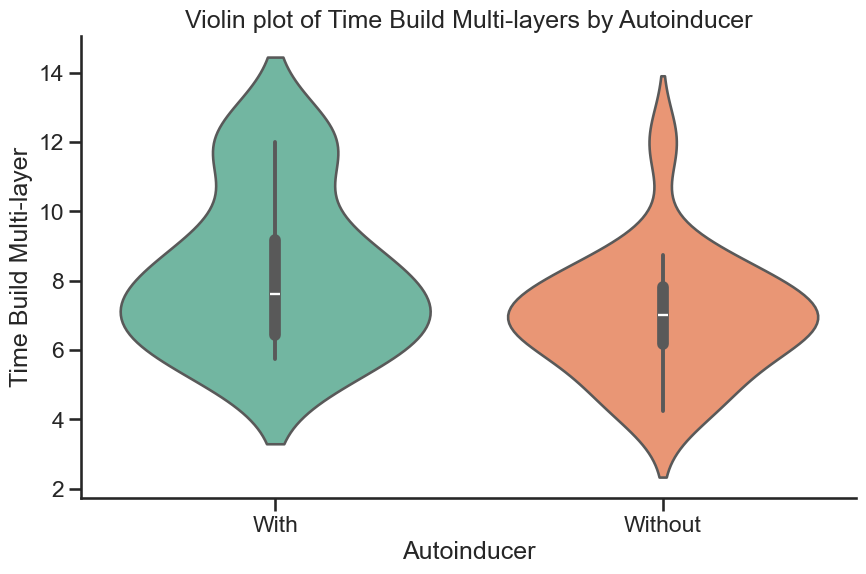

In [9]:
# plot
sns.violinplot(data=df_layer_1, x='Autoinducer', y='time', hue='Autoinducer', palette='Set2')
plt.title('Violin plot of Time Build Multi-layers by Autoinducer')
plt.xlabel('Autoinducer')
plt.ylabel('Time Build Multi-layer')
plt.show()

## Exogenous AI over time

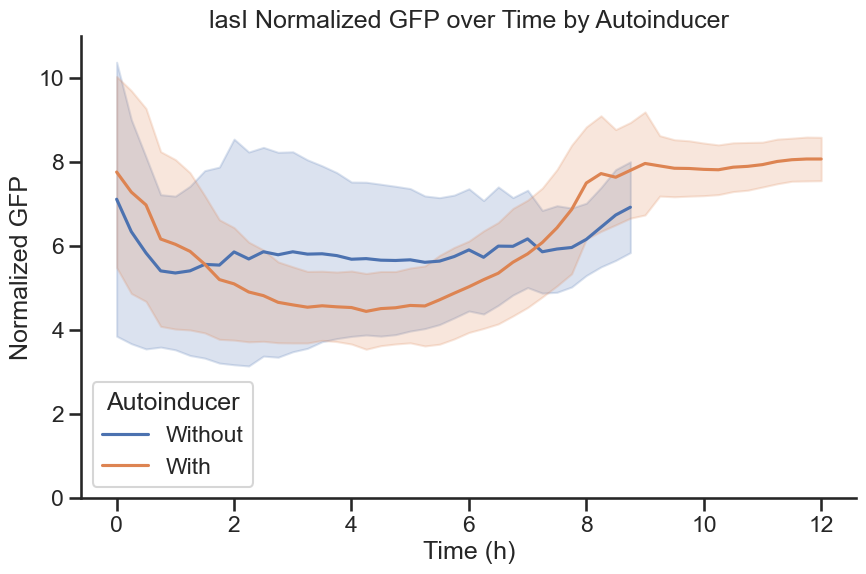

In [10]:
# replace the gene to the interest
gene = 'lasI'

df_gene = df_all[df_all['gene'] == gene]
sns.lineplot(data=df_gene, x='time', y='normalized_GFP', hue='Autoinducer', estimator='mean', errorbar='sd')
plt.ylim(0, 11)
plt.title(f'{gene} Normalized GFP over Time by Autoinducer')
plt.xlabel('Time (h)')
plt.ylabel('Normalized GFP')
plt.show()

## Exogenous AI on gene expression - box plot

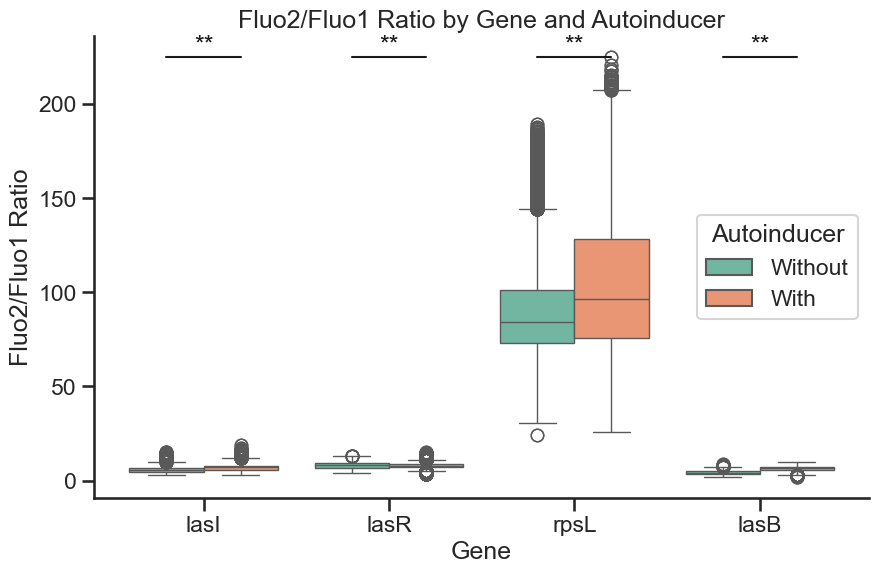

In [11]:
# Create the boxplot
sns.boxplot(data=df_all, x='gene', y='normalized_GFP', hue='Autoinducer', palette='Set2')
plt.title('Fluo2/Fluo1 Ratio by Gene and Autoinducer')
plt.xlabel('Gene')
plt.ylabel('Fluo2/Fluo1 Ratio')

# Perform statistical analysis and annotate
genes = df_all['gene'].unique()
for gene in genes:
    with_ai = df_all[(df_all['gene'] == gene) & (df_all['Autoinducer'] == 'With')]['normalized_GFP']
    without_ai = df_all[(df_all['gene'] == gene) & (df_all['Autoinducer'] == 'Without')]['normalized_GFP']
    
    t_stat, p_val = ttest_ind(with_ai, without_ai)
    
    if p_val < 0.01:
        annotation = '**'
    elif p_val < 0.05:
        annotation = '*'
    else:
        annotation = 'NS'
    
    # Annotate the plot
    x1, x2 = genes.tolist().index(gene) - 0.2, genes.tolist().index(gene) + 0.2
    y, h, col = df_all['normalized_GFP'].max() + 0.1, 0.02, 'k'
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
    plt.text((x1 + x2) * .5, y + h, annotation, ha='center', va='bottom', color=col)

# plt.legend(title='Autoinducer')
plt.show()

## Plot for cell and colony level gene expression

In [16]:
# calculate colony or cell level fluorescence for plotting
colony_cell_nGFP_mean = df_all.groupby(['gene', 'cluster', 'time']).agg(
    nGFP_mean=('normalized_GFP', 'mean'),
    nGFP_std=('normalized_GFP', 'std')
).reset_index()

colony_area_sum = df_all.groupby(['gene', 'cluster', 'time']).agg(
    area_sum=('area', 'sum')
).reset_index()


colony_cells_count = df_all.groupby(['gene', 'cluster', 'time']).agg(
    cells_count=('id', 'count')
).reset_index()


colony_cell_fluo_mean = df_all.groupby(['gene', 'cluster', 'time']).agg(
    fluo1_mean=('fluo1', 'mean'),
    fluo1_std=('fluo1', 'std'),
    fluo2_mean=('fluo2', 'mean'),
    fluo2_std=('fluo2', 'std'),
).reset_index()

colony_fluo_sum = df_all.groupby(['gene', 'cluster', 'time']).agg(
    fluo1_sum=('fluo1', 'sum'),
    fluo2_sum=('fluo2', 'sum')
).reset_index()

gene_colony_fluo_mean = colony_cell_fluo_mean.groupby(['gene', 'time']).agg(
    fluo1_mean=('fluo1_mean', 'mean'),
    fluo1_std=('fluo1_std', 'mean'),
    fluo2_mean=('fluo2_mean', 'mean'),
    fluo2_std=('fluo2_std', 'mean')
).reset_index()

In [8]:
df_all.groupby('gene').cluster.nunique()

gene
lasB     9
lasI    10
lasR    11
rpsL    12
Name: cluster, dtype: int64

## plot colony/cell-level gene expression over time

In [6]:
# # log transform for sum / filter out rpsL
# colony_fluo_sum['log_fluo2_sum'] = np.log10(colony_fluo_sum['fluo2_sum'])
# cell_fluo_mean_without_rpsL = cell_fluo_mean[cell_fluo_mean['gene'] != 'rpsL']

def average_plot(dataset, x, y, hue, titile, sciencific_notation=False):
    '''
    plot average line plot for each gene
    '''
    
    sns.lineplot(data=dataset, 
                 x=x, 
                 y=y, 
                 hue=hue,
                 estimator='mean',
                 linewidth=3,
                 palette='colorblind'
                 )

    plt.ylim(1, 11)

    # plt.title(titile)
    plt.xlabel('Time (h)', fontsize=24)
    plt.ylabel('Normalized GFP', fontsize=24)

    unique_clusters = dataset.groupby('gene').cluster.nunique()
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = [f"{gene} (n={unique_clusters[gene]})" for gene in labels]
    plt.legend(handles, new_labels, title='Gene', loc='upper left')
    
    if sciencific_notation:
        plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
        plt.gca().yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=True))
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))  
    
    plt.show()
    

def line_plot(dataset, x, y, hue, units, titile, sciencific_notation=False):
    '''
    plot line plot for each cluster
    '''
    
    sns.lineplot(data=dataset, 
                 x=x, 
                 y=y, 
                 hue=hue,
                 units=units,
                 estimator=None,
                 alpha=0.5,
                 linewidth=1,
                 palette='colorblind'
                 )

    plt.title(titile)
    
    if sciencific_notation:
        plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
        plt.gca().yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=True))
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))  
    
    plt.show()
    
def line_average_plot(df, std=False):
    '''
    plot line plot for each cluster with average and standard deviation for each gene
    '''

    # Plot individual lines for each gene-cluster combination
    sns.lineplot(data=df, x="time", y="nGFP_mean", hue="gene", style="cluster", legend=False, linewidth=1, palette='colorblind', alpha=0.5)

    # Calculate mean and standard deviation for each gene at each time point
    df_mean_std = df.groupby(['gene', 'time']).agg(mean=('nGFP_mean', 'mean'), std=('nGFP_mean', 'std')).reset_index()

    # Plot the average line for each gene
    sns.lineplot(data=df_mean_std, x="time", y="mean", hue="gene", linewidth=2.5)

    # Add standard deviation shadow (fill_between)
    if std:
        for gene in df_mean_std['gene'].unique():
            subset = df_mean_std[df_mean_std['gene'] == gene]
            plt.fill_between(subset['time'], 
                            subset['mean'] - subset['std'], 
                            subset['mean'] + subset['std'], 
                            alpha=0.2)

    # Customize the plot
    plt.title("Cluster and Mean Normalized GFP Intensity per Gene")

    # plt.xlabel("Time")
    # plt.ylabel("Normalized GFP")
    # plt.legend(title="Gene")
    plt.show()

In [16]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

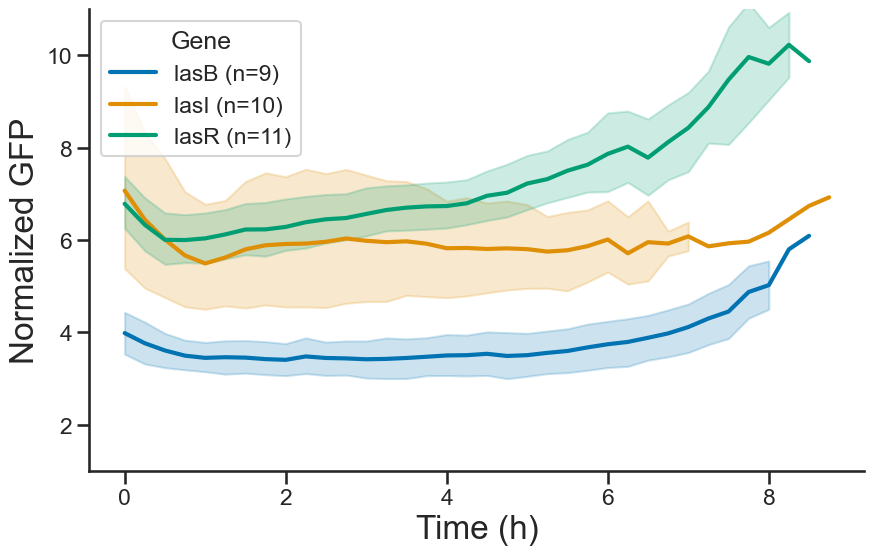

In [10]:
# use case
colony_cell_nGFP_mean_without_rpsL = colony_cell_nGFP_mean[colony_cell_nGFP_mean['gene'] != 'rpsL']  
average_plot(colony_cell_nGFP_mean_without_rpsL, 'time', 'nGFP_mean', 'gene', 'Normalized GFP over time', sciencific_notation=False)

In [ ]:
# use case
line_average_plot(colony_cell_nGFP_mean_without_rpsL, std=True)

In [ ]:
# Now calculate the CV (coefficient of variation) after the aggregation
colony_cell_fluo_mean['fluo1_cv'] = colony_cell_fluo_mean['fluo1_std'] / colony_cell_fluo_mean['fluo1_mean']
colony_cell_fluo_mean['fluo2_cv'] = colony_cell_fluo_mean['fluo2_std'] / colony_cell_fluo_mean['fluo2_mean']


# Plot lines with error bars (CI), instead of shading
sns.lineplot(data=colony_cell_fluo_mean, x="time", y="fluo2_cv", hue="gene", 
             style="gene", palette='colorblind',markers=True, dashes=False)

# Customize the plot
plt.title("GFP coefficient of variation")
plt.xlabel("Time")
plt.ylabel("CV (%)")

plt.show()

In [21]:
colony_cell_nGFP_mean = colony_cell_nGFP_mean[colony_cell_nGFP_mean['gene'] != 'rpsL']
colony_cell_nGFP_mean = colony_cell_nGFP_mean[~((colony_cell_nGFP_mean['gene'] == 'lasI') & (colony_cell_nGFP_mean['time'] > 8))]

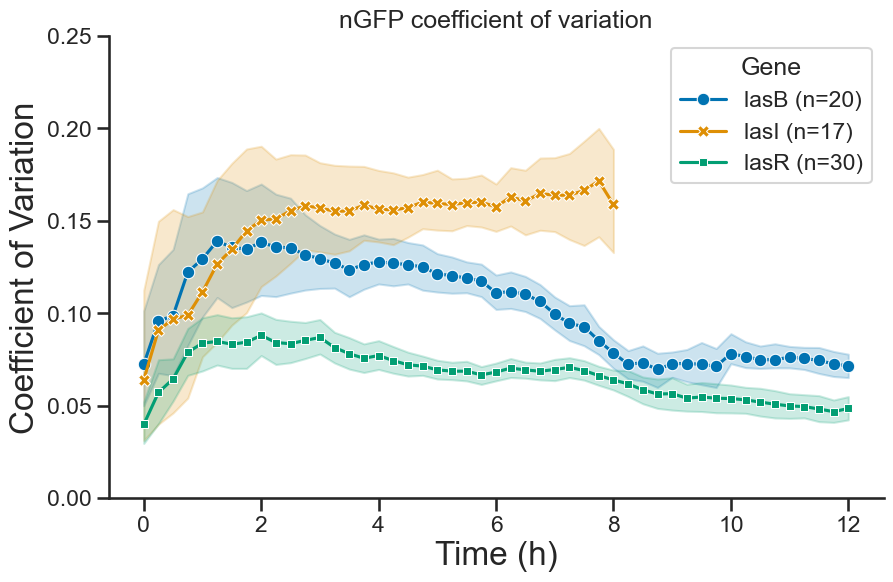

In [22]:
colony_cell_nGFP_mean['nGFP_cv'] = colony_cell_nGFP_mean['nGFP_std'] / colony_cell_nGFP_mean['nGFP_mean']


# Plot lines with error bars (CI), instead of shading
sns.lineplot(data=colony_cell_nGFP_mean, x="time", y="nGFP_cv", hue="gene", 
             style="gene", palette='colorblind' ,markers=True, dashes=False)

# Customize the plot
plt.title("nGFP coefficient of variation")
plt.xlabel("Time (h)", fontsize=24)
plt.ylabel("Coefficient of Variation", fontsize=24)

plt.ylim(0, 0.25)
 
unique_clusters = colony_cell_nGFP_mean.groupby('gene').cluster.nunique()
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [f"{gene} (n={unique_clusters[gene]})" for gene in labels]
plt.legend(handles, new_labels, title='Gene', loc='upper right')

plt.show()

In [ ]:
average_plot(colony_cell_nGFP_mean, 'time', 'nGFP_cv', 'gene', 'nGFP coefficient of variation', sciencific_notation=False)